## Imports

In [13]:
import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")  # silence LAL warnings
from pyseobnr.generate_waveform import GenerateWaveform, generate_modes_opt
import lal
import lalsimulation as lalsim
import astropy.units as u
from lalsimulation.gwsignal import (
    GenerateFDWaveform,
    GenerateTDModes,
    GenerateTDWaveform,
)
from lalsimulation.gwsignal.models import gwsignal_get_waveform_generator
import matplotlib.pyplot as plt
import numpy as np
import bilby
from math import fmod

## hoft generator

In [2]:
def convert_numpy_to_lal(numpy_array, deltaT):
    ht = lal.CreateREAL8TimeSeries("ht", lal.LIGOTimeGPS(0.), 0. , deltaT, lal.DimensionlessUnit, len(numpy_array))
    ht.data.data = numpy_array
    return ht

In [3]:
#Antenna pattern functions                                                                                                                                                                                                                                  
def Fplus(theta, phi, psi):
    """                                                                                                                         
    Antenna pattern as a function of polar coordinates measured from                                                            
    directly overhead a right angle interferometer and polarization angle                                                       
    """
    return 0.5*(1. + np.cos(theta)*np.cos(theta))*np.cos(2.*phi)*np.cos(2.*psi)\
            - np.cos(theta)*np.sin(2.*phi)*np.sin(2.*psi)

def Fcross(theta, phi, psi):
    """                                                                                                                         
    Antenna pattern as a function of polar coordinates measured from                                                            
    directly overhead a right angle interferometer and polarization angle                                                       
    """
    return 0.5*(1. + np.cos(theta)*np.cos(theta))*np.cos(2.*phi)*np.sin(2.*psi)\
            + np.cos(theta)*np.sin(2.*phi)*np.cos(2.*psi)

In [4]:
def hpc_to_hoft(theta, phi, psi, hp, hc, deltaF=None, deltaT=None):
    fp = Fplus(theta, phi, psi)
    fc = Fcross(theta, phi, psi)
    hp.data.data *= fp
    hc.data.data *= fc
    hp = lal.AddREAL8TimeSeries(hp, hc)
    ht = hp
    #if P.taper != lsu_TAPER_NONE: # Taper if requested                                                                          
    #    lalsim.SimInspiralREAL8WaveTaper(ht.data, P.taper)
    if deltaF is not None:
        TDlen = int(1./deltaF * 1./deltaT)
        #print(TDlen, ht.data.length)
        assert TDlen >= ht.data.length
        ht = lal.ResizeREAL8TimeSeries(ht, 0, TDlen)
    return ht

In [5]:
def tvals(ht):
    tvals = np.arange(0, ht.data.length * ht.deltaT, ht.deltaT)
    peak = np.argwhere(ht.data.data**2 == np.max(ht.data.data**2))[0][0]
    return tvals - tvals[peak]

In [6]:
def hoft_generator(gwsignal_dict,wf_gen,deltaT,deltaF,theta,phi,psi):
    hpc = GenerateTDWaveform(gwsignal_dict, wf_gen)
    hp_arr = hpc.hp
    hc_arr = hpc.hc
    hp = convert_numpy_to_lal(hp_arr, deltaT)
    hc = convert_numpy_to_lal(hc_arr, deltaT)
    ht = hpc_to_hoft(theta, phi, psi, hp, hc, deltaF, deltaT)
    return ht

In [ ]:
# # start with the usual parameter definitions

# # Masses

# m2 = mtot/(q+1)
# m1 = mtot - m2

# # spins
# s1x = 0.0
# s1y = 0.0
# s1z = 0.5
# s2x = 0.0
# s2y = 0.0
# s2z = 0.5

# # Extrinsic parameters
# deltaT = 1.0 / 2048 / 2.0
# f_min = fmin
# f_max = 2048
# f_ref = fmin
# luminosity_distance = 4500
# psi = 0.
# theta = np.pi/3
# phi = np.pi/6
# iota = np.pi / 3.0
# phase = 2.3

# # Eccentric parameters
# eccentricity = ecc
# longitude_ascending_nodes = 0.
# meanPerAno = 0.5

# # Conditioning
# condition = 1
# deltaF = 1.0 / 8.0  # /20.

In [7]:
def wf_params_ecc(m1, m2, s1x, s1y, s1z, s2x, s2y, s2z, deltaT, 
                  f_min, f_max, f_ref, luminosity_distance, psi, theta, 
                  phi, iota, phase, eccentricity, longitude_ascending_nodes, 
                  meanPerAno, condition, lmax, lmax_nyquist, deltaF):

    # Create dict for gwsignal generator
    gwsignal_dict = {
        "mass1": m1 * u.solMass,
        "mass2": m2 * u.solMass,
        "spin1x": s1x * u.dimensionless_unscaled,
        "spin1y": s1y * u.dimensionless_unscaled,
        "spin1z": s1z * u.dimensionless_unscaled,
        "spin2x": s2x * u.dimensionless_unscaled,
        "spin2y": s2y * u.dimensionless_unscaled,
        "spin2z": s2z * u.dimensionless_unscaled,
        #'deltaF' : delta_frequency * u.Hz,
        "deltaT": deltaT * u.s,
        #'deltaF': deltaF*u.Hz,
        "f22_start": f_min * u.Hz,
        "f_max": f_max * u.Hz,
        "f22_ref": f_ref * u.Hz,
        "phi_ref": phase * u.rad,
        "distance": luminosity_distance * u.Mpc,
        "inclination": iota * u.rad,
        "eccentricity": eccentricity * u.dimensionless_unscaled,
        "longAscNodes": longitude_ascending_nodes * u.rad,
        "meanPerAno": meanPerAno * u.rad,
        # 'ModeArray': mode_array,
        "condition": condition,
        "lmax": lmax,
        "lmax_nyquist": lmax_nyquist,
        # Some additional specific SEOBNRv5EHM parameters
        "secular_bwd_int": True,
        "warning_secular_bwd_int": False,
        "t_backwards": 0,
        "warning_bwd_int": False,
    }
    
    waveform_approximant = "SEOBNRv5EHM"
    
    try:
        wf_gen = gwsignal_get_waveform_generator(waveform_approximant)
    except ValueError as e:
        if str(e) != "Approximant not implemented in GWSignal!":
            raise
    
        wf_gen = None
        print("SEOBNRv5EHM not supported by this version of lal")
    ht = hoft_generator(gwsignal_dict,wf_gen,deltaT,deltaF,theta,phi,psi)
    return ht

In [37]:
#Based on IMRPhenomNSBH:LowSpin highest likelihood point from LVK GW200105 samples

# Masses
m1 = 8.741082482004446
m2 = 2.162761279562819

# Spins
s1x = 0.0
s1y = 0.0
s1z = -0.07443819135153053
s2x = 0.0
s2y = 0.0
s2z = -0.03167082572099747

# Extrinsic parameters
deltaT = 1.0 / 2048 / 2.0
f_min = 20
f_max = 2048
f_ref = 20
luminosity_distance = 362.5136705230262
psi = 1.1864755949271302
ra = 1.2055184248799407
dec = -0.12906498250155196
gps_time = 1262276684.06
gmst = lal.GreenwichMeanSiderealTime(gps_time)
theta, phi = bilby.core.utils.conversion.ra_dec_to_theta_phi(ra, dec, gmst)
iota = 3.0063383311714054
phase = 3.1771242031241766

# Eccentric parameters
eccentricity = 0.6
longitude_ascending_nodes = 0.
meanPerAno = 0.

# Conditioning
condition = 1
deltaF = 1.0 / 4000.0  # /20.

# modes
lmax = 4
lmax_nyquist = 1

In [38]:
ht_ecc_test = wf_params_ecc(m1, m2, s1x, s1y, s1z, s2x, s2y, s2z, deltaT, 
                  f_min, f_max, f_ref, luminosity_distance, psi, theta, 
                  phi, iota, phase, eccentricity, longitude_ascending_nodes, 
                  meanPerAno, condition, lmax, lmax_nyquist, deltaF)

(-0.5, 0.1)

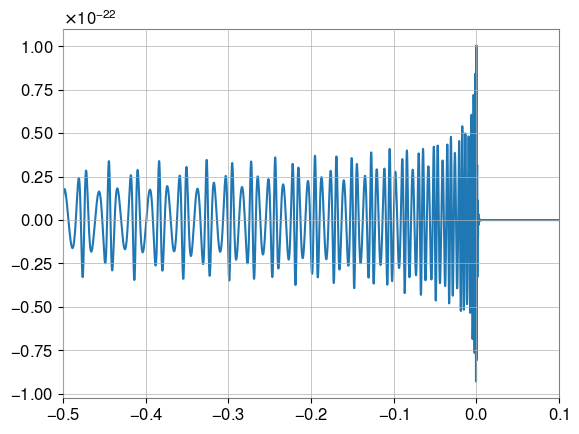

In [39]:
plt.plot(tvals(ht_ecc_test), ht_ecc_test.data.data)
plt.xlim(-0.5,0.1)
#plt.legend()

In [58]:
e_range = np.linspace(0,0.9,10)
inc_range = np.linspace(0,np.pi/2,7)
results=[]
for e in e_range:
    for inc in inc_range:
        try:
            wf_params_ecc(m1, m2, s1x, s1y, s1z, s2x, s2y, s2z, deltaT, 
                          f_min, f_max, f_ref, luminosity_distance, psi, theta, 
                          phi, inc, phase, e, longitude_ascending_nodes, 
                          meanPerAno, condition, lmax, lmax_nyquist, deltaF)
            success_flag = 1
        except Exception:
            success_flag = 0
        results.append((e, inc, success_flag))
        
           
            
        

ERROR:pyseobnr.eob.dynamics.integrate_ode_ecc:Internal function call failed: Input domain error. The computed value of the dimensionless starting orbit-averaged frequency (x_avg_computed = 0.01733814879906681) differs from the expected value (x_avg_expected = 0.021844130456211492) by 20.628% > 10%. Aborting the waveform generation since this is related to the application of the model in a region outside its domain of validity. Please, review the physical sense of the input parameters.
ERROR:pyseobnr.models.SEOBNRv5EHM:Waveform generation failed for q = 4.041630745197811, chi_1 = -0.07443819135153053, chi_2 = -0.03167082572099747, omega_avg = 0.0032285100474194594, omega_inst = 0.04300534530668249, eccentricity = 0.9029246364760142, rel_anomaly = 4.968190330564758. Reference values: eccentricity_ref = 0.9, rel_anomaly_ref = 0.0, omega_avg_ref = 0.003374496745041981.
ERROR:pyseobnr.eob.dynamics.integrate_ode_ecc:Internal function call failed: Input domain error. The computed value of the

In [59]:
results_array = np.array(results)

/tmp/ipykernel_532866/2033830849.py:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  success_matrix[i, j] = results_array[(results_array[:, 0] == e) & (results_array[:, 1] == inc), 2]


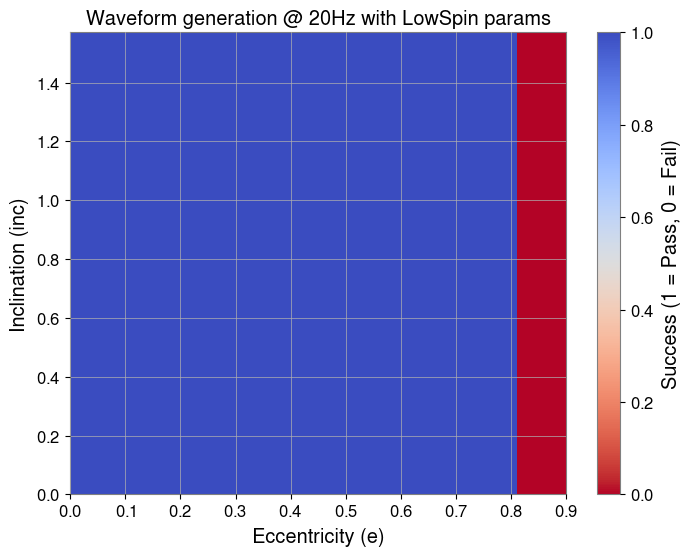

In [72]:
import numpy as np
import matplotlib.pyplot as plt

# Reshape results for visualization
e_values = np.unique(results_array[:, 0])  # Unique e values
inc_values = np.unique(results_array[:, 1])  # Unique inc values

# Create a 2D array to store success values
success_matrix = np.zeros((len(e_values), len(inc_values)))

for i, e in enumerate(e_values):
    for j, inc in enumerate(inc_values):
        success_matrix[i, j] = results_array[(results_array[:, 0] == e) & (results_array[:, 1] == inc), 2]

# Plot heatmap
plt.figure(figsize=(8, 6))
plt.imshow(success_matrix.T, origin="lower", aspect="auto", 
           extent=[e_values.min(), e_values.max(), inc_values.min(), inc_values.max()],
           cmap="coolwarm_r", vmin=0, vmax=1)

plt.colorbar(label="Success (1 = Pass, 0 = Fail)")
plt.xlabel("Eccentricity (e)")
plt.ylabel("Inclination (inc)")
plt.title("Waveform generation @ 20Hz with LowSpin params")
plt.savefig("wfGenCheck_20Hz_LowSpin.png", bbox_inches='tight', dpi=300)
plt.show()


In [41]:
e_range

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

In [44]:
inc_range = np.linspace(0,np.pi/2,7)
inc_range

array([0.        , 0.26179939, 0.52359878, 0.78539816,
       1.04719755, 1.30899694, 1.57079633])

In [56]:
arr=np.zeros((3, 3, 3))


In [57]:
arr[0][1][2]

0.0

In [54]:
arr[0]

(1, 2, 3)

In [71]:
wf_params_ecc(100, 100, s1x, s1y, s1z, s2x, s2y, s2z, deltaT, 
                          f_min, f_max, f_ref, luminosity_distance, psi, theta, 
                          phi, 0.3, phase, 0.1, longitude_ascending_nodes, 
                          meanPerAno, condition, lmax, lmax_nyquist, deltaF)

<Swig Object of type 'tagREAL8TimeSeries *' at 0x7f6bd0ae6ab0>